### **TEMPO O3 validation**

This notebook illustrates comparison of TEMPO ozone total column retrievals with Pandora ground stations and DSCOVR EPIC retrievals.

It allows a user to choose Pandora station of interest. Since TEMPO spatial coverage is regional and limited to North America, it is user's responsibilty to select the station within TEMPO's field of regard (FOR). If the selected station is outside FOR, no TEMPO time series will be generated.

The user is allowed to choose the time period of interest by providing start and end dates in the form YYYYMMDD. Please be aware, that if the selecte period of interest is outside of available time span of one of the sensors, corresponding time series will not be generated.

DSCOVR L2 O3 data are interpolated to the location of the selected Pandora station.

Data files for all 3 sensors are downloaded on-the-fly. TEMPO and DSCOVR data are downloaded with earthaccess library that needs to be installed first.

TEMPO data files are read by means of netCDF library that needs to be installed first.

Pandora data files are ASCII files with header and space separated columns. Custome made function is included to read nitrogen dioxide total column along with its total uncertainty.

The resulting time series are plotted with and without uncertainty of both measurement in the end of the notebook.

# 1 Installing and importing necessary libraries

## 1.1 Installing netCDF

In [ ]:
! pip3 install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.3 MB/s eta 0:00:00


## 1.2 Installing earthaccess

In [ ]:
! pip3 install earthaccess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 47.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
    Uninstalling fsspec-2023.6.0:
      Successfully uninstalled fsspec-2023.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2023.6.0 requires fsspec==2023.6.0, but you have fsspec 2023.12.2 which is incompatible.


## 1.3 Importing necessary libraries

In [ ]:
import earthaccess # needed to discover and download TEMPO data
import netCDF4 as nc # needed to read TEMPO data

import os
import sys

import platform
from subprocess import Popen
import shutil

from shapely.geometry import Point, Polygon # needed to search a point within a polygon
from scipy.interpolate import griddata # needed to interpolate TEMPO data to the point of interest

import requests # needed to search for and download Pandora data
import codecs # needed to read Pandora data
import numpy as np
import h5py # needed to read DSCOVR_EPIC_L2_TO3 files
import matplotlib.pyplot as plt # needed to plot the resulting time series
from urllib.request import urlopen, Request # needed to search for and download Pandora data
from pathlib import Path # needed to check whether a needed data file is already downloaded
from datetime import datetime, timedelta # needed to work with time in plotting time series

# 2 Establishing access to EarthData

## 2.1 Logging in

User needs to create an account at https://www.earthdata.nasa.gov/

Function earthaccess.login prompts for EarthData login and password.

In [ ]:
auth = earthaccess.login(strategy="interactive", persist=True)

Enter your Earthdata Login username: alexrad71
Enter your Earthdata password: ··········
Persisting credentials to .netrc


## 2.2 Creating local directory

In [ ]:
homeDir = os.path.expanduser("~") + os.sep

with open(homeDir + '.dodsrc', 'w') as file:
    file.write('HTTP.COOKIEJAR={}.urs_cookies\n'.format(homeDir))
    file.write('HTTP.NETRC={}.netrc'.format(homeDir))
    file.close()

print('Saved .dodsrc to:', homeDir)

# Set appropriate permissions for Linux/macOS
if platform.system() != "Windows":
    Popen('chmod og-rw ~/.netrc', shell=True)
else:
    # Copy dodsrc to working directory in Windows
    shutil.copy2(homeDir + '.dodsrc', os.getcwd())
    print('Copied .dodsrc to:', os.getcwd())

Saved .dodsrc to: /root/


# 3 Working with Pandora data

## 3.0 Managing security certificate issue

This step is needed only if there is a security certificate problem with Pandora data web site,  http://data.pandonia-global-network.org/. Should be avoided otherwise.

In [ ]:
'''
Pandora data web site,  url = 'http://data.pandonia-global-network.org/',
currently has its security certificate expired. In order to make this code
working, urlopen(url) was replaced by urlopen(url,context=context).
2 lines below are needed to bypass certificate check.
Once the site certificate is up-to-date,
these lines can be removed and usual call of urlopen can be restored.
'''
import ssl
context = ssl._create_unverified_context()

## 3.1 Defining a function gathering the list of available Pandora sites

If there is a security certificate problem with Pandora data web site,  http://data.pandonia-global-network.org/, un-comment line

page = urlopen(url,context=context)

and comment out

page = urlopen(url)

In [ ]:
'''
function read_pandora_web returns the list of available Pandora sites
'''
def read_pandora_web():
  url = 'https://data.pandonia-global-network.org/'
  page = urlopen(url)
#  page = urlopen(url,context=context)
  html_bytes = page.read()
  html = html_bytes.decode("utf-8")
  html_len = len(html)

  pos1 = 0

  big_line = str(html)
  lines = big_line.split('\n')

  ref_lines = [i for i in lines if 'href' in i]
  refs = []
  for line in ref_lines:
    pos1 = line.find('"')
    pos2 = line.rfind('"')
    if pos1 > 0 and pos2 > pos1 and line[pos2-1] =='/' and line[pos1+1] == '.':
      refs.append(line[pos1+3 : pos2-1])

  return refs

## 3.2 Defining functions allowing user to choose a Pandora site of interest

In [ ]:
'''
function check_site checks whether user entered site is in the list of available Pandora sites
'''
def check_site(site_name, refs):
  site_list = []
  for line in refs:
    if site_name in line:
      site_list.append(line)

  return site_list

'''
function take_pandora_sites takes user input and checks whether the site is in the list of available Pandora sites
'''
def take_pandora_sites(refs):
  print('please select a Pandora site name from the list')
  for ref in refs:
    print(ref)

  answer = 'y'
  while answer == 'y':
    site_name = input('Enter a name of a Pandora site: ')
    print(site_name)
    site_list = check_site(site_name, refs)
    site_num = len(site_list)
    if site_num == 0:
      print('site ', site_name, 'was not found')
      continue

    if site_num > 1:
      print('there are ', site_num, ' site names, select one from')
      for site in site_list: print(site)

      site_name = input('Enter an exact name of a Pandora site: ')
      if site_list.count(site_name) != 1:
        print('Entered name is not the exact match of one of the following sites')
        for site in site_list: print(site)
        print('program terminated')
        sys.exit()

      for site in site_list:
        if site == site_name:
          pandora_site = site_name
          print('site ', site_name, 'was found and added to the list of sites ')
          break

    if site_num == 1:
      pandora_site = site_list[0]
      print('site ', site_list[0], 'was found and added to the list of sites ')

    answer = 'n'

  return pandora_site

## 3.3 Defining a function creating the list links to O3 data files at the selected Pandora sites

Pandora site may have several instruments. In this case each instrument has its own directory. However, the most recent version of the NO2 data, rnvs3p1-8, is available only in one of these directories. The function creates all possible links, but some of them may be non-existing. This is chacked and cleared later.

If there is a security certificate problem with Pandora data web site,  http://data.pandonia-global-network.org/, un-comment line

page = urlopen(url,context=context)

and comment out

page = urlopen(url)

In [ ]:
'''
function instrument_path returns links to available Pandora O3 retrievals files
'''
def instrument_path(site):
  url = 'https://data.pandonia-global-network.org/' + site + '/'
  page = urlopen(url)
#  page = urlopen(url,context=context)
  html_bytes = page.read()
  html = html_bytes.decode("utf-8")
  html_len = len(html)

  pos1 = 0
  big_line = str(html)
  lines = big_line.split('\n')

  ref_lines = [i for i in lines if 'href' in i]
  links = []
  for line in ref_lines:

    pos1 = line.find('"')
    pos2 = line.rfind('"')
    if pos1 > 0 and pos2 > pos1 and line[pos2-1] =='/' and\
       line[pos1+3 : pos1 + 10] == 'Pandora':
      link = url + line[pos1+3 : pos2] + 'L2/' + line[pos1+3 : pos2-1] + '_' + site + '_L2_rout2p1-8.txt'
      print(link)
      links.append(link)

  return links

## 3.4 Defining functions downloading Pandora data file with given url

If there is a security certificate problem with Pandora data web site, http://data.pandonia-global-network.org/, un-comment line

response = requests.get(url, verify=False)

and comment out

page = response = requests.get(url)

In [ ]:
'''
function download downloads file with given url
'''
def download(url):
  response = requests.get(url)
#  response = requests.get(url, verify=False)
  response_code = response.status_code

  file_name = url.split('/')[-1]

  if response_code == 200:
    content = response.content
    data_path = Path(file_name)
    data_path.write_bytes(content)

  return file_name, response_code

## 3.5 Defining functions converting Pandora timestamp into a set of  year, month, day, hour, minute, and second

In [ ]:
'''
function read_timestamp converts Pandora timestamp of the format
'yyyymmddThhmmssZ' into a set of 6 numbers:
integer year, month, day, hour, minute, and real second.
'''
def read_timestamp(timestamp):

  yyyy = int(timestamp[0:4])
  mm = int(timestamp[4:6])
  dd = int(timestamp[6:8])
  hh = int(timestamp[9:11])
  mn = int(timestamp[11:13])
  ss = float(timestamp[13:17])

  return yyyy, mm, dd, hh, mn, ss

## 3.6 Defining function reading Pandora O3 data file rout2p1-8

In [ ]:
'''
function read_Pandora_O3_rout2p1_8 reads Pandora total NO2 column data files
ending with rout2p1-8.

Arguments:
fname - name file to be read, string;
start_date - beginning of the time interval of interest,
             integer of the form YYYYMMDD;
end_date -   end of the time interval of interest,
             integer of the form YYYYMMDD.

if start_date is greater than end_date, the function returns a numpy array
with shape (0, 8), otherwise it returns an 8-column numpy array
with with columns being year, month, day, hour, minute, second of observation
and retrieved total O3 column along with its total uncertainty.

O3 column and its uncertainties are in mol/m^2, so conversion to Dobson Units is
performed by multiplication by DU_conversion = 1./4.4615E-04

'''
def read_Pandora_O3_rout2p1_8(fname, start_date, end_date):

  DU_conversion = 1./4.4615E-04


  data = np.empty([0, 8])
  if start_date > end_date: return -999., -999., data

  with codecs.open(fname, 'r', encoding='utf-8', errors='ignore') as f:

    while True:
# Get next line from file
      line = f.readline()

      if line.find('Short location name:') >= 0:
        loc_name = line.split()[-1] # location name, to be used in the output file name
        print('location name ', loc_name)

      if line.find('Location latitude [deg]:') >= 0:
        lat = float(line.split()[-1]) # location latitude
        print('location latitude ', lat)

      if line.find('Location longitude [deg]:') >= 0:
        lon = float(line.split()[-1]) # location longitude
        print('location longitude ', lon)

      if line.find('--------') >= 0: break

    while True:
# Get next line from file
      line = f.readline()

      if line.find('--------') >= 0: break

    while True:
# now reading line with data
      line = f.readline()

      if not line: break

      line_split = line.split()

      yyyy, mm, dd, hh, mn, ss = read_timestamp(line_split[0])
      date_stamp = yyyy*10000 + mm*100 + dd
      if date_stamp < start_date or date_stamp > end_date: continue

      column = float(line_split[38]) # Ozone total vertical column amount [moles per square meter]
      if column < 0.: continue

#      column_unc = float(line_split[42]) # Total uncertainty of ozone total vertical column amount [moles per square meter]
#      if column_unc < 0.: continue

      column_unc = float(line_split[43]) # rms-based uncertainty of ozone total vertical column amount [moles per square meter]
      if column_unc < 0.: continue

      data_line = np.array([yyyy, mm, dd, hh, mn, ss\
                          , column*DU_conversion, column_unc*DU_conversion])
      data = np.append(data, [data_line], axis = 0)

  return lat, lon, loc_name, data

## 3.7 Discovering existing Pandora stations and selecting one of them

In [ ]:
# Discovering available Pandora site.
# Please bear in mind that some sites do not have O3 data files
print('gathering Pandora sites information')
refs = read_pandora_web()

pandora_site = take_pandora_sites(refs) # create list of Pandora sites of interest
print('the following sites were selected')
print(pandora_site)
print('from the list of existing Pandora sites')

# create a list of !AVAILABLE! Pandora files for the Pandora site
pandora_files = []

links = instrument_path(pandora_site)

npfiles = 0

for link in links:
  pandora_fname = link.split('/')[-1]

# check if file exists in the local directory, if not download from Pandora site
  if not os.path.exists(pandora_fname):
    print(pandora_fname,' does not exit in local directory, downloading from the web')
    print(link)

    pandora_fname, response_code = download(link)

    if response_code == 200:
      print('Pandora L2 file ', pandora_fname, ' has been downloaded')
      npfiles = npfiles + 1
      pandora_files.append(pandora_fname)
    else:
      print('Pandora L2 file ', link, ' does not exist')

  else:
    print(pandora_fname,' exits in local directory')
    npfiles = npfiles + 1
    pandora_files.append(pandora_fname)

if npfiles == 0: # no files were found, STOP here
  print('no files were found for Pandora site ', pandora_site, 'program terminated')
  sys.exit()
if npfiles > 1: # normally there should be only one file per site. if there are more - STOP
  print('there are too many files for site ', pandora_site, '- STOP and investigate file names below. Program terminated')
  for pandora_fname in pandora_files:
    print(pandora_fname)
  sys.exit()

gathering Pandora sites information
please select a Pandora site name from the list
Agam
AldineTX
AliceSprings
Altzomoni
ArlingtonTX
Athens-NOA
AtlantaGA-SouthDeKalb
AtlantaGA
Bandung
Bangkok
Banting
BayonneNJ
Beijing-RADI
BeltsvilleMD
Berlin
BlueHillMA
BostonMA
BoulderCO-NCAR
BoulderCO
Bremen
BristolPA
BronxNY
Brussels-Uccle
Bucharest
BuenosAires
BuffaloNY
Busan
Cabauw
CambridgeMA
CapeElizabethME
ChapelHillNC
CharlesCityVA
ChicagoIL
ClearLakeShoresTX
Cologne
ComodoroRivadavia
Cordoba
Dalanzadgad
Davos
DearbornMI
Dhaka
Downsview
EastProvidenceRI
EdwardsCA
Egbert
Eureka-PEARL
FairbanksAK
Fajardo
FortMcKay
Fukuoka
Granada
GreenbeltMD
HamptonVA-HU
HamptonVA
Helsinki
HoustonTX
HuntsvilleAL
Incheon-ESC
Innsbruck
Islamabad-NUST
Izana
Juelich
KenoshaWI
Kobe
LaPorteTX
Lindenberg
LondonderryNH
LynnMA
MadisonCT
ManhattanKS
ManhattanNY-CCNY
MaunaLoaHI
MexicoCity-UNAM
MexicoCity-Vallejo
MountainViewCA
Nagoya
NewBrunswickNJ
NewHavenCT
NyAlesund
OldFieldNY
Palau
PhiladelphiaPA
PittsburghPA
Pontianak

## 3.8 Selecting timeframe of interest

It is going to be common for both instruments

In [ ]:
print('enter period of interest, start and end dates, in the form YYYYMMDD')
datestamp_ini = input('enter start date of interest ')
datestamp_fin = input('enter end date of interest ')

start_date = int(datestamp_ini)
end_date = int(datestamp_fin)

yyyy_ini = start_date//10000
mm_ini = (start_date//100 - yyyy_ini*100)
dd_ini = (start_date - yyyy_ini*10000 - mm_ini*100)

yyyy_fin = end_date//10000
mm_fin = (end_date//100 - yyyy_fin*100)
dd_fin = (end_date - yyyy_fin*10000 - mm_fin*100)
print(yyyy_ini, mm_ini, dd_ini, yyyy_fin, mm_fin, dd_fin)

date_start = str('%4.4i-%2.2i-%2.2i 00:00:00' %(yyyy_ini, mm_ini, dd_ini))
date_end = str('%4.4i-%2.2i-%2.2i 23:59:59' %(yyyy_fin, mm_fin, dd_fin))

enter period of interest, start and end dates, in the form YYYYMMDD
enter start date of interest 20231103
enter end date of interest 20231103
2023 11 3 2023 11 3


## 3.9 Reading Pandora file within selected timeframe and create point of interest

In [ ]:
pandora_file = pandora_files[0]
lat, lon, POI_name, Pandora_data = read_Pandora_O3_rout2p1_8(pandora_file, start_date, end_date)

if lat == -999.:
  print('error reading pandora file ', pandora_file, 'program terminated')
  sys.exit()

POI = np.array([lat, lon])

location name  BoulderCO
location latitude  39.99
location longitude  -105.26


In [ ]:
print(Pandora_data)

[[2.02300000e+03 1.10000000e+01 3.00000000e+00 1.40000000e+01
  3.80000000e+01 5.75000000e+01 2.63745377e+02 3.70077328e+01]
 [2.02300000e+03 1.10000000e+01 3.00000000e+00 1.40000000e+01
  4.40000000e+01 1.18000000e+01 2.67914379e+02 5.32668385e+01]
 [2.02300000e+03 1.10000000e+01 3.00000000e+00 1.40000000e+01
  4.80000000e+01 3.73000000e+01 2.67824723e+02 2.42183122e+01]
 [2.02300000e+03 1.10000000e+01 3.00000000e+00 1.40000000e+01
  5.30000000e+01 5.90000000e+01 2.68407486e+02 1.89369046e+01]
 [2.02300000e+03 1.10000000e+01 3.00000000e+00 1.50000000e+01
  3.00000000e+00 3.38000000e+01 2.68945422e+02 1.32603385e+01]
 [2.02300000e+03 1.10000000e+01 3.00000000e+00 1.50000000e+01
  1.30000000e+01 3.20000000e+00 2.68429900e+02 9.68979043e+00]
 [2.02300000e+03 1.10000000e+01 3.00000000e+00 1.50000000e+01
  1.90000000e+01 3.18000000e+01 2.69236804e+02 9.41589152e+00]
 [2.02300000e+03 1.10000000e+01 3.00000000e+00 1.50000000e+01
  3.40000000e+01 4.66000000e+01 2.72576488e+02 6.84769696e+00]


#4 Working with DSCOVR data

## 4.1 Searching DSCOVR data files within 0.5 degree range around the POI (position of the Pandora station)

In [ ]:
short_name = 'DSCOVR_EPIC_L2_TO3' # collection name to search for in the EarthData

POI_lat = POI[0]
POI_lon = POI[1]

bbox = (POI_lon - 0.5, POI_lat - 0.5, POI_lon + 0.5, POI_lat + 0.5)
POI_results_EPIC = earthaccess.search_data(short_name = short_name,
                                    temporal = (date_start, date_end),
                                    bounding_box = bbox)

print('total number of DSCOVR EPIC L2_TO3 granules found for POI', POI_name, \
      '\nwithin period of interes between', date_start, 'and', date_end, \
      '\nis', len(POI_results_EPIC))

Granules found: 0
total number of DSCOVR EPIC L2_TO3 granules found for POI BoulderCO 
within period of interes between 2023-10-30 00:00:00 and 2023-10-30 23:59:59 
is 0


In [ ]:
granule_links_EPIC = []
for result in POI_results_EPIC: granule_links_EPIC.append(result['umm']['RelatedUrls'][0]['URL'])

for granule_link in granule_links_EPIC: print(granule_link)

### 4.1.0 Searching DSCOVR data files without bounding box

It appears that as of now, January 19, 2024, earthaccess returns incorrect granules for DSCOVR product covering anti-meridian. For this reason, all available granules should be grabbed using earthaccess function search_data without bounding box. Granules that do not contain the point of interest will be processed, but the code below, in section 4.5 will handle them correctly without generating either errors or fill value outcome.

In [ ]:
short_name = 'DSCOVR_EPIC_L2_TO3' # collection name to search for in the EarthData

POI_results_EPIC = earthaccess.search_data(short_name = short_name,
                                    temporal = (date_start, date_end))

print('total number of DSCOVR EPIC L2_TO3 granules found for POI', POI_name, \
      '\nwithin period of interes between', date_start, 'and', date_end, \
      '\nis', len(POI_results_EPIC))

Granules found: 0
total number of DSCOVR EPIC L2_TO3 granules found for POI BoulderCO 
within period of interes between 2023-11-03 00:00:00 and 2023-11-03 23:59:59 
is 0


##4.1.1 Print links to the available data files

In [ ]:
granule_links_EPIC = []
for result in POI_results_EPIC: granule_links_EPIC.append(result['umm']['RelatedUrls'][0]['URL'])

for granule_link in granule_links_EPIC: print(granule_link)

In [ ]:
downloaded_files = earthaccess.download(
    POI_results_EPIC,
    local_path='.',)

ValueError: List of URLs or DataGranule isntances expected

In [ ]:
cnt = 0
for granule_link_EPIC in granule_links_EPIC:
  EPIC_fname = granule_link.split('/')[-1]

# check if file exists in the local directory, if not download from Pandora site
  if not os.path.exists(EPIC_fname):
    print(EPIC_fname, 'does not exist in local directory')
    cnt += 1

print(cnt)

0


##4.2 Define function reading DSCOVR_EPIC_L2_TO3

###4.2.1 Define function reading DSCOVR_EPIC_L2_TO3

This is the older version, it does NOT read time variable. In order to retrieve time,timestamp from the file name needs to be processed.

In [ ]:
def read_epic_l2_to3(fname):
# function read_epic_l2_aer reads DSCOVR_EPIC_L2_TO3 product file given by its fname
# and returns arrays of wavelengths, 2D latitudes and longitudes, and total O3 column along with their fill values.

  try:
    f = h5py.File(fname, "r" )
  except:
    print("Unable to find or read hdf5 input granule file ", fname)
    return 0., 0., 0., 0., 0.

  try:
    item = f['Latitude']
    lat2D = item[:]
#    fv_geo = item.fillvalue
    fv_geo = lat2D[0, 0]
  except:
    print("Unable to find or read hdf5 input granule file ", fname)
    return 0., 0., 0., 0., 0.

  try:
    item = f['Longitude']
    lon2D = item[:]
  except:
    print("Unable to find or read hdf5 input granule file ", fname)
    return 0., 0., 0., 0., 0.

  try:
    item = f['Ozone']
    o3_2D = item[:]
# commented out line below is the general way to read the fill value
# however, attribute '_FillValue' is not set for any array in the current version of the product
# at the same time, arrays do have apparent fill values that can be seen in the
# corners of the image
#    fv_o3 = item.fillvalue
    fv_o3 = o3_2D[0, 0]
  except:
    print("Unable to find or read hdf5 input granule file ", fname)
    return 0., 0., 0., 0., 0.

  f.close()

  return lat2D, lon2D, o3_2D, fv_o3, fv_geo

###4.2.2 Define function reading DSCOVR_EPIC_L2_TO3

This is the new version, it reads time variable.

In [ ]:
def read_epic_l2_to3(fname):
# function read_epic_l2_to3 reads DSCOVR_EPIC_L2_TO3 product file given by its fname
# and returns arrays of wavelengths, 2D latitudes and longitudes, and total O3 column along with their fill values.

  try:
    f = h5py.File(fname, "r" )
  except:
    print("Unable to find or read hdf5 input granule file ", fname)
    return 0., 0., 0., 0., 0., 0.

  try:
    item = f['Latitude']
    lat2D = item[:]
#    fv_geo = item.fillvalue
    fv_geo = lat2D[0, 0]
  except:
    print("Unable to read 'Latitude' from granule file ", fname)
    return 0., 0., 0., 0., 0., 0.

  try:
    item = f['Longitude']
    lon2D = item[:]
  except:
    print("Unable to read 'Longitude' from granule file ", fname)
    return 0., 0., 0., 0., 0., 0.

  try:
    item = f['Ozone']
    o3_2D = item[:]
# commented out line below is the general way to read the fill value
# however, attribute '_FillValue' is not set for any array in the current version of the product
# at the same time, arrays do have apparent fill values that can be seen in the
# corners of the image
#    fv_o3 = item.fillvalue
    fv_o3 = o3_2D[0, 0]
  except:
    print("Unable to read 'Ozone' from granule file ", fname)
    return 0., 0., 0., 0., 0., 0.

  try:
    item = f['YearDaySeconds']
    YearDaySeconds = item[:] # this is an array of 3 elements: year, day of the year, and seconds of the day
  except:
    print("Unable to read 'YearDaySeconds' from granule file ", fname)
    return 0., 0., 0., 0., 0., 0.


  f.close()

  return lat2D, lon2D, o3_2D, fv_o3, fv_geo, YearDaySeconds

#4.3 Compile DSCOVR EPIC total ozone timeseries

In [ ]:
days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

geo_deviation = 0.2 # deviation from the point of interest, degree

POI_name_ = POI_name.replace(' ','_')
out_Q_EPIC = 'tot_O3_EPIC'
out_Q_unit = 'DU'

fout = open(out_Q_EPIC+'_'+datestamp_ini+'_'+datestamp_fin+'_'+POI_name_+'_'+str('%08.4fN_%08.4fW' %(POI[0], -POI[1])), 'w')
fout.write('timeseries of '+out_Q_EPIC+' at '+POI_name+' '+str('%08.4fN %08.4fW' %(POI[0], -POI[1]))+'\n')
fout.write('yyyy mm dd hh mn ss '+out_Q_unit+'\n')

for result in POI_results_EPIC:
  granule_link = result['umm']['RelatedUrls'][0]['URL']
  last_slash_ind = granule_link.rfind('/')
  fname = granule_link[last_slash_ind+1 : ]
  print(fname)
#  lat2D, lon2D, o3_2D, fv_o3, fv_geo  = read_epic_l2_to3(fname) # this is for the version not reading YearDaySeconds array
  lat2D, lon2D, o3_2D, fv_o3, fv_geo, YearDaySeconds  = read_epic_l2_to3(fname)

  if isinstance(lat2D, float): continue

  print(fv_geo)

  nx = lon2D.shape[0]
  ny = lon2D.shape[1]

# getting time from the granule filename
  '''
  fname_split = fname.split('_')
  timestamp = fname_split[-2]
  yyyy= int(timestamp[0 : 4])
  mm = int(timestamp[4 : 6])
  dd = int(timestamp[6 : 8])
  hh = int(timestamp[8 : 10])
  mn = int(timestamp[10 : 12])
  ss = int(timestamp[12 : 14])'''

# check whether POI is in the granule. If not - move to the next granule
  mask = (lat2D < POI_lat+geo_deviation)&(lat2D > POI_lat-geo_deviation)\
        &(lon2D < POI_lon+geo_deviation)&(lon2D > POI_lon-geo_deviation)\
        &(o3_2D != fv_o3)

  lat_loc = lat2D[mask]
  lon_loc = lon2D[mask]
  o3_loc = o3_2D[mask]
  n_loc = len(o3_loc)
  if n_loc < 1: continue

  pp = np.array([POI[1], POI[0]])
  points = np.empty([0,2])
  ff = np.empty(0)

  for i in range(n_loc):
    if o3_loc[i] == fv_o3: continue
    points = np.append(points, [[lon_loc[i], lat_loc[i]]], axis=0)
    ff = np.append(ff, o3_loc[i])

  try:
    [prod_loc] = griddata(points, ff, pp, method='linear', fill_value=-1., rescale=False)
    print(prod_loc)
  except:
    try:
      prod_loc = np.mean(ff)
      print(prod_loc, ff)
    except: continue

# handling time first:
  yyyy= int(YearDaySeconds[0])
  dd = int(YearDaySeconds[1])
  sec = int(YearDaySeconds[2])

  md = days.copy()
  if (yyyy//4)*4 == yyyy: md[1] = md[1] + 1

  for i in range(12):
    if dd > md[i]: dd = dd - md[i]
    else:
      mm = i + 1
      break

  hh = sec//3600
  mn = sec//60 - hh*60
  ss = sec - hh*3600 - mn*60

  print(yyyy, mm, dd, hh, mn, ss, prod_loc)

  fout.write(str('%4.4i %2.2i %2.2i %2.2i %2.2i %2.2i %10.3e '\
%(yyyy, mm, dd, hh, mn, ss, prod_loc)))
  for i in range(n_loc):
    fout.write(str('%9.4fN %9.4fW %10.3e '\
%(lat_loc[i], -lon_loc[i], o3_loc[i])))
  fout.write('\n')

fout.close()

#5 Working with TEMPO data

##5.1 Setting TEMPO name constants

In [ ]:
short_name = 'TEMPO_O3TOT_L2' # collection name to search for in the EarthData
out_Q = 'tot_O3_col' # name of the output quantity with unit
out_Q_unit = out_Q+',_DU' # name of the output quantity with unit

##5.2 Searching TEMPO data files within 0.5 degree range around the POI (position of the Pandora station)

In [ ]:
POI_lat = POI[0]
POI_lon = POI[1]

bbox = (POI_lon - 0.5, POI_lat - 0.5, POI_lon + 0.5, POI_lat + 0.5)
POI_results = earthaccess.search_data(short_name = short_name,
                                    temporal = (date_start, date_end),
                                    bounding_box = bbox)

print('total number of granules found for POI', POI_name, \
      '\nwithin period of interes between', date_start, 'and', date_end, \
      '\nis', len(POI_results))

Granules found: 11
total number of granules found for POI BoulderCO 
within period of interes between 2023-11-03 00:00:00 and 2023-11-03 23:59:59 
is 11


###5.2.0 Printing explicit links to the granules

This can be dropped off

In [ ]:
granule_links = []
for result in POI_results: granule_links.append(result['umm']['RelatedUrls'][0]['URL'])

for granule_link in granule_links: print(granule_link)

https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V01/2023.11.03/TEMPO_O3TOT_L2_V01_20231103T150156Z_S005G07.nc
https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V01/2023.11.03/TEMPO_O3TOT_L2_V01_20231103T160156Z_S006G07.nc
https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V01/2023.11.03/TEMPO_O3TOT_L2_V01_20231103T170156Z_S007G07.nc
https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V01/2023.11.03/TEMPO_O3TOT_L2_V01_20231103T180156Z_S008G07.nc
https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V01/2023.11.03/TEMPO_O3TOT_L2_V01_20231103T190156Z_S009G07.nc
https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V01/2023.11.03/TEMPO_O3TOT_L2_V01_20231103T200156Z_S010G07.nc
https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V01/2023.11.03/TEMPO_O3TOT_L2_V01_20231103T210156Z_S011G07.nc
https://data.asdc.ea

##5.3 Downloading TEMPO data files

In [ ]:
downloaded_files = earthaccess.download(
    POI_results,
    local_path='.',
)

 Getting 11 granules, approx download size: 0.0 GB


QUEUEING TASKS | :   0%|          | 0/11 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/11 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/11 [00:00<?, ?it/s]

###5.3.0 Checking whether all TEMPO data files

This can be dropped off, but it can be useful to ensure that all TEMPO files are downloaded. If the outcom is '0' then all is done

In [ ]:
cnt = 0
for granule_link in granule_links:
  TEMPO_fname = granule_link.split('/')[-1]

# check if file exists in the local directory, if not download from Pandora site
  if not os.path.exists(TEMPO_fname):
    print(TEMPO_fname, 'does not exist in local directory')
    cnt += 1

print(cnt)

0


##5.4 Defining function reading TEMPO O3 data file

In [ ]:
def read_TEMPO_O3TOT_L2(fn):
  '''
  function read_TEMPO_O3TOT_L2 reads the following arrays from the
  TEMPO L2 O3 product TEMPO_O3TOT_L2_V01:
    column_amount_o3;
  and returns respective fields along with coordinates of the pixels
  and their corners and fill values of all variables.

  If one requested variables cannot be read, all returned variables are zeroed
  '''
  ds = nc.Dataset(fn)

  prod = ds.groups['product'] # this opens group product, /product, as prod

  var_name = 'column_amount_o3'
  try:
    var = prod.variables[var_name] # this reads variable column_amount_o3 from prod (group product, /product)
    total_O3_column = np.array(var)
    fv_prod = var.getncattr('_FillValue')
    prod_unit = var.getncattr('units')

  except:
    print('variable '+var_name+' cannot be read in file '+fn)
    lat = 0.
    lon = 0.
    time = 0.
    fv_geo = 0.
    total_O3_column = 0.
    fv_prod = 0.
    prod_unit = ''
    return lat, lon, fv_geo, time, total_O3_column, fv_prod, prod_unit

  geo = ds.groups['geolocation'] # this opens group geolocation, /geolocation, as geo

  lat = np.array(geo.variables['latitude']) # this reads variable latitude from geo (geolocation group, /geolocation) into a numpy array
  lon = np.array(geo.variables['longitude']) # this reads variable longitude from geo (geolocation group, /geolocation) into a numpy array
  fv_geo = geo.variables['latitude'].getncattr('_FillValue')
  time = np.array(geo.variables['time'] )# this reads variable longitude from geo (geolocation group, /geolocation) into a numpy array

  return lat, lon, fv_geo, time, total_O3_column, fv_prod, prod_unit


##5.5 Defining function creating TEMPO O3 granule polygon

In [ ]:
def TEMPO_L2_polygon(lat, lon, fv_geo):
  nx = lon.shape[0]
  ny = lon.shape[1]
  print(nx, ny)

  dpos = np.empty([0,2])

  x_ind = np.empty([nx, ny], dtype = int) # creating array in x indices
  for ix in range(nx): x_ind[ix, :] = ix # populating array in x indices
  y_ind = np.empty([nx, ny], dtype = int)
  for iy in range(ny): y_ind[:, iy] = iy # populating array in x indices

  mask = (lon[ix, iy] != fv_geo)&(lat[ix, iy] != fv_geo)
  if len(lon[mask]) == 0:
    print('the granule is empty - no meaningful positions')
    return dpos

# right boundary
  r_m = min(x_ind[mask].flatten())
  local_mask = (lon[r_m, :] != fv_geo)&(lat[r_m, :] != fv_geo)
  r_b = np.stack((lon[r_m, local_mask], lat[r_m, local_mask])).T

# left boundary
  l_m = max(x_ind[mask].flatten())
  local_mask = (lon[l_m, :] != fv_geo)&(lat[l_m, :] != fv_geo)
  l_b = np.stack((lon[l_m, local_mask], lat[l_m, local_mask])).T
#  sys.exit()

#top and bottom boundaries
  t_b = np.empty([0,2])
  b_b = np.empty([0,2])
  for ix in range(r_m + 1, l_m):
    local_mask = (lon[ix, :] != fv_geo)&(lat[ix, :] != fv_geo)
    local_y_ind = y_ind[ix, local_mask]
    y_ind_top = min(local_y_ind)
    y_ind_bottom = max(local_y_ind)
    t_b = np.append(t_b, [[lon[ix, y_ind_top], lat[ix, y_ind_top]]], axis=0)
    b_b = np.append(b_b, [[lon[ix, y_ind_bottom], lat[ix, y_ind_bottom]]], axis=0)

# combining right, top, left, and bottom boundaries together, going along the combined boundary counterclockwise
  dpos = np.append(dpos, r_b[ : :-1, :], axis=0) # this adds right boundary, counterclockwise
  dpos = np.append(dpos, t_b, axis=0) # this adds top boundary, counterclockwise
  dpos = np.append(dpos, l_b, axis=0) # this adds left boundary, counterclockwise
  dpos = np.append(dpos, b_b[ : :-1, :], axis=0) # this adds bottom boundary, counterclockwise

  return dpos

##5.6 Compiling TEMPO O3 total column time series

In [ ]:
days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

POI_name_ = POI_name.replace(' ','_')

fout = open(out_Q+'_'+datestamp_ini+'_'+datestamp_fin+'_'+POI_name_+'_'+str('%08.4fN_%08.4fW' %(POI[0], -POI[1])), 'w')
fout.write('timeseries of '+out_Q+' at '+POI_name+' '+str('%08.4fN %08.4fW' %(POI[0], -POI[1]))+'\n')
fout.write('yyyy mm dd hh mn ss '+out_Q_unit+'\n')

for result in POI_results:
  granule_link = result['umm']['RelatedUrls'][0]['URL']
  last_slash_ind = granule_link.rfind('/')
  fname = granule_link[last_slash_ind+1 : ]
  print(fname)
  lat, lon, fv_geo, time, total_O3_column, fv_prod, prod_unit\
  = read_TEMPO_O3TOT_L2(fname)

  if isinstance(lat, float): continue

# it appeared that garbage values of latitudes and longitudes in the L2 files are 9.969209968386869E36
# while fill value is -1.2676506E30
# (after deeper search it was found that actual values in the file is -1.2676506002282294E30).
# For this reason, fv_geo is set to 9.96921E36 to make code working.
# once the problem is resolved and garbage values of latitudes and longitudes equal to its fill value,
# the line below must be removed.
  fv_geo = 9.969209968386869E36

  polygon = TEMPO_L2_polygon(lat, lon, fv_geo)
  print(polygon.shape)

  coords_poly = list(polygon)
  poly = Polygon(coords_poly)

  nx = lon.shape[0]
  ny = lon.shape[1]

# getting time from the granule filename
  Tind = fname.rfind('T')
  yyyy= int(fname[Tind-8 : Tind-4])
  mm = int(fname[Tind-4 : Tind-2])
  dd = int(fname[Tind-2 : Tind])
  hh = int(fname[Tind+1 : Tind+3])
  mn = int(fname[Tind+3 : Tind+5])
  ss = float(fname[Tind+5 : Tind+7])

# check whether POI is in the granule. If not - move to the next granule
  pp = np.array([POI[1], POI[0]])
  p = Point(pp) # POI[0] - latitudes, POI[1] - longitudes
  if not p.within(poly): continue
  print('point', p, 'is in granule polygon' )

  POI_found = False
  for ix in range(nx-1):
    for iy in range(ny-1):
      if lon[ix, iy] == fv_geo: continue
      if lat[ix, iy] == fv_geo: continue
      if lon[ix, iy+1] == fv_geo: continue
      if lat[ix, iy+1] == fv_geo: continue
      if lon[ix+1, iy+1] == fv_geo: continue
      if lat[ix+1, iy+1] == fv_geo: continue
      if lon[ix+1, iy] == fv_geo: continue
      if lat[ix+1, iy] == fv_geo: continue

      coords_poly_loc = [[lon[ix, iy], lat[ix, iy]], [lon[ix, iy+1], lat[ix, iy+1]] \
                   , [lon[ix+1, iy+1], lat[ix+1, iy+1]], [lon[ix+1, iy], lat[ix+1, iy]]]
      poly_loc = Polygon(coords_poly_loc)

      if p.within(poly_loc):

        print(ix, iy, lat[ix, iy], lon[ix, iy]\
            , total_O3_column[ix, iy])
        print(ix, iy+1, lat[ix, iy+1], lon[ix, iy+1]\
            , total_O3_column[ix, iy+1])
        print(ix+1, iy+1, lat[ix+1, iy+1], lon[ix+1, iy+1]\
            , total_O3_column[ix+1, iy+1])
        print(ix+1, iy, lat[ix+1, iy], lon[ix+1, iy]\
            , total_O3_column[ix+1, iy])

        POI_found = True
        print('POI', POI_name, 'at', POI[1], POI[0], ' found')

        points = np.empty([0,2])
        ff = np.empty(0)
        points_unc = np.empty([0,2])
        ff_unc = np.empty(0)

        if total_O3_column[ix, iy] != fv_prod:
          points = np.append(points, [[lon[ix, iy], lat[ix, iy]]], axis=0)
          ff = np.append(ff, total_O3_column[ix, iy])

        if total_O3_column[ix, iy+1] != fv_prod:
          points = np.append(points, [[lon[ix, iy+1], lat[ix, iy+1]]], axis=0)
          ff = np.append(ff, total_O3_column[ix, iy+1])

        if total_O3_column[ix+1, iy+1] != fv_prod:
          points = np.append(points, [[lon[ix+1, iy+1], lat[ix+1, iy+1]]], axis=0)
          ff = np.append(ff, total_O3_column[ix+1, iy+1])

        if total_O3_column[ix+1, iy] != fv_prod:
          points = np.append(points, [[lon[ix+1, iy], lat[ix+1, iy]]], axis=0)
          ff = np.append(ff, total_O3_column[ix+1, iy])

        if ff.shape[0] == 0:
          continue
        elif ff.shape[0] < 4:
          prod_loc = np.mean(ff)
        elif ff.shape[0] == 4:
          [prod_loc] = griddata(points, ff, pp, method='linear', fill_value=-1., rescale=False)

        if prod_loc < 0.: continue

# handling time first:
        delta_t = (time[ix+1] + time[ix])*0.5 - time[0]
        ss = ss + delta_t
        if ss >= 60.:
          delta_mn = int(ss/60.)
          ss = ss - 60.*delta_mn
          mn = mn + delta_mn
          if mn >= 60:
            mn = mn - 60
            hh = hh + 1
            if hh == 24:
              hh = hh - 24
              dd = dd + 1
              day_month = days[mm]
              if (yyyy//4)*4 == yyyy and mm == 2: day_month = day_month + 1
              if dd > day_month:
                dd = 1
                mm = mm + 1
                if mm > 12:
                  mm = 1
                  yyyy = yyyy + 1

        fout.write(str('%4.4i %2.2i %2.2i %2.2i %2.2i %2.2i %10.3e '\
%(yyyy, mm, dd, hh, mn, ss, prod_loc)))
        fout.write(str('%9.4fN %9.4fW %10.3e '\
%(lat[ix, iy], -lon[ix, iy], total_O3_column[ix, iy])))
        fout.write(str('%9.4fN %9.4fW %10.3e '\
%(lat[ix, iy+1], -lon[ix, iy+1], total_O3_column[ix, iy+1])))
        fout.write(str('%9.4fN %9.4fW %10.3e '\
%(lat[ix+1, iy+1], -lon[ix+1, iy+1], total_O3_column[ix+1, iy+1])))
        fout.write(str('%9.4fN %9.4fW %10.3e\n'\
%(lat[ix+1, iy], -lon[ix+1, iy], total_O3_column[ix+1, iy])))

        break

    if POI_found: break

fout.close()

TEMPO_O3TOT_L2_V01_20231103T150156Z_S005G07.nc
131 2048
(4354, 2)
point POINT (-105.26 39.99) is in granule polygon
20 694 40.002373 -105.23424 265.50677
20 695 39.981533 -105.22905 264.29205
21 695 39.979023 -105.286476 268.13052
21 694 40.001945 -105.29276 266.12485
POI BoulderCO at -105.26 39.99  found
TEMPO_O3TOT_L2_V01_20231103T160156Z_S006G07.nc
131 2048
(4354, 2)
point POINT (-105.26 39.99) is in granule polygon
21 695 40.00962 -105.256546 272.9443
21 696 39.98879 -105.25135 270.89578
22 696 39.985245 -105.30844 273.00555
22 695 40.00915 -105.31525 269.48877
POI BoulderCO at -105.26 39.99  found
TEMPO_O3TOT_L2_V01_20231103T170156Z_S007G07.nc
131 2048
(4354, 2)
point POINT (-105.26 39.99) is in granule polygon
20 694 39.99604 -105.21864 275.2817
20 695 39.975155 -105.21344 274.49786
21 695 39.974785 -105.272224 275.07233
21 694 39.996113 -105.27769 275.15555
POI BoulderCO at -105.26 39.99  found
TEMPO_O3TOT_L2_V01_20231103T180156Z_S008G07.nc
131 2048
(4354, 2)
point POINT (-105.2

#6 Plotting the results

##6.1 Reading created data files for TEMPO and DSCOVR, create timeseries

In [ ]:
# reading TEMPO file that was created at the previous step
# only read POI information from the header and first 8 columns of data:
#   yyyy, mm, dd, hh, mn, ss, NO2 column, and its incertainty
fout = open(out_Q+'_'+datestamp_ini+'_'+datestamp_fin+'_'+POI_name_+'_'+str('%08.4fN_%08.4fW' %(POI[0], -POI[1])), 'r')

header1 = fout.readline()
header2 = fout.readline()
data_lines = fout.readlines()

fout.close()

time_series_TEMPO = np.empty([0, 2])

if len(data_lines) > 0:
  split = data_lines[0].split()
  yyyy = int(split[0])
  mm = int(split[1])
  dd = int(split[2])
  hh = 0
  mn = 0
  ss = 0
  dt0 = datetime(yyyy, mm, dd, hh, mn, ss)

  for line in data_lines:
    split = line.split()
    yyyy = int(split[0])
    mm = int(split[1])
    dd = int(split[2])
    hh = int(split[3])
    mn = int(split[4])
    ss = int(split[5])
# dt below is time since the beginning of the eriod of interest in hours
    dt = (datetime(yyyy, mm, dd, hh, mn, ss) - dt0).total_seconds()/86400.
    time_series_TEMPO = np.append(time_series_TEMPO,\
 [[dt, float(split[6])]], axis = 0)

# reading DSCOVR file that was created at the previous step
# only read POI information from the header and first 8 columns of data:
#   yyyy, mm, dd, hh, mn, ss, and O3 column
fout = open(out_Q_EPIC+'_'+datestamp_ini+'_'+datestamp_fin+'_'+POI_name_+'_'+str('%08.4fN_%08.4fW' %(POI[0], -POI[1])), 'r')

header1 = fout.readline()
header2 = fout.readline()
data_lines = fout.readlines()

fout.close()

time_series_DSCOVR = np.empty([0, 2])

if len(data_lines) > 0:
  split = data_lines[0].split()
  yyyy = int(split[0])
  mm = int(split[1])
  dd = int(split[2])
  hh = 0
  mn = 0
  ss = 0
  dt0 = datetime(yyyy, mm, dd, hh, mn, ss)

  for line in data_lines:
    split = line.split()
    yyyy = int(split[0])
    mm = int(split[1])
    dd = int(split[2])
    hh = int(split[3])
    mn = int(split[4])
    ss = int(split[5])
# dt below is time since the beginning of the eriod of interest in hours
    dt = (datetime(yyyy, mm, dd, hh, mn, ss) - dt0).total_seconds()/86400.
    time_series_DSCOVR = np.append(time_series_DSCOVR,\
 [[dt, float(split[6])]], axis = 0)

time_series_Pandora = np.empty([0, 3])

for line in Pandora_data:
  yyyy = int(line[0])
  mm = int(line[1])
  dd = int(line[2])
  hh = int(line[3])
  mn = int(line[4])
  ss = int(line[5])
#  dt = datetime(yyyy, mm, dd, hh, mn, ss)
# dt below is time since the beginning of the eriod of interest in hours
  dt = (datetime(yyyy, mm, dd, hh, mn, ss) - dt0).total_seconds()/86400.
#  time_series_Pandora = np.append(time_series_Pandora,\
#[[(dt - dt0).total_seconds()/86400., line[6]]], axis = 0)
  time_series_Pandora = np.append(time_series_Pandora,\
[[dt, line[6], line[7]]], axis = 0)


##6.2 Plotting timeseries

###6.2.1 No error bars

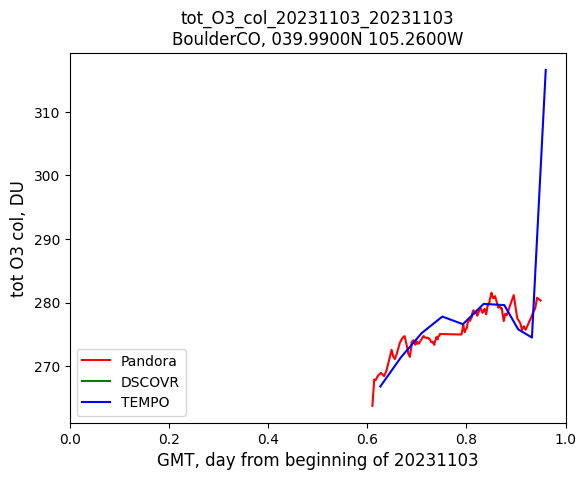

In [ ]:
plot_title = out_Q+'_'+datestamp_ini+'_'+datestamp_fin+'\n'+POI_name
img_name = out_Q+'_'+datestamp_ini+'_'+datestamp_fin+'_'+POI_name+'.jpg'

plt.plot(time_series_Pandora[:, 0], time_series_Pandora[:, 1],\
         label = "Pandora", c = 'r')
plt.plot(time_series_DSCOVR[:, 0], time_series_DSCOVR[:, 1],
         label = "DSCOVR", c = 'g')
plt.plot(time_series_TEMPO[:, 0], time_series_TEMPO[:, 1],
         label = "TEMPO", c = 'b')

# Set the range of x-axis
l_lim = int(min(time_series_TEMPO[:, 0]))
u_lim = int(max(time_series_TEMPO[:, 0])) + 1
plt.xlim(l_lim, u_lim)

# some research is required to set the vertical range
plt.xlabel(r'GMT, day from beginning of '+datestamp_ini, fontsize=12)
plt.ylabel(out_Q_unit.replace('_',' '), fontsize=12)

plt.legend(loc='lower left')

plt.title(plot_title+str(', %08.4fN %08.4fW' %(POI[0], -POI[1])))
plt.savefig(img_name, format='jpg', dpi=300)

###6.2.2 Smooth Pandora retievals and interplate them into other time series times

Pandora timeseries has significantly more data points then TEMPO and DSCOVR. It is also very noisy. To make comparison easier, Pandora timeseries is interpolated to the moments of TEMPO and DSCOVR observations.

Interpolation is performed by the function defined below with the help of Gaussian smooting as follow:

x_int(t) = SUM(x_p(t_i)*wt(t_i, t)),

wt(t_i, t) = exp(-(t - t_i)^2/(2 * sigma^2))/SUM(exp(-(t - t_i)^2/(2 * sigma^2))),

where sums are taken over times t_i falling into time interval (t-dt_max, t+dt_max).

Parameters dt_max and sigma can be chosen by the user. In the example below they are

dt_max = 0.00041666667  - 10 minutes expressed in days

sigma = 0.00041666667  - 1 minute expressed in days

In [ ]:
def gauss_interpolation(timeseries, new_times):
#
# function gauss_interpolation takes 2D array timeseries with function
# to be interpolated and 1D array new_times containing times to which
# the function is to be interpolated
# arguments:
#     timeseries - array with at least 2 columns,
#                  1st column - times, 2nd (3rd, ...) column(s) - function to be interpolated
#     new_times  - 1D array of times to which the function(s) to be interpolated
#
# parameters
# dt_max = 0.0041666667 - 10 minutes expressed in days
# sigma = 0.00041666667 - 1 minute expressed in days

  dt_max = 0.0041666667 # 10 minutes expressed in days
  sigma = 0.00041666667 # 1 minute expressed in days

  nnt = len(new_times)
  (nt, nfun) = timeseries.shape

  timeseries_smooth = np.empty([0, nfun])

  for new_time in new_times:
    llim = new_time - dt_max
    ulim = new_time + dt_max

    timeseries_subset = timeseries[((timeseries[:, 0] < ulim)\
                                    & (timeseries[:, 0] > llim))]
    if len(timeseries_subset) < 1: continue
    t_delta = timeseries_subset[:, 0] - new_time
    wt = np.exp(-t_delta**2/(2.*sigma**2))
    wt = wt/np.sum(wt)

    timeseries_smooth_loc = np.array([new_time])
    for ifun in range(1, nfun):
      timeseries_smooth_loc = np.append(timeseries_smooth_loc,\
                                        np.sum(timeseries_subset[:, ifun]*wt))

    timeseries_smooth = np.append(timeseries_smooth,\
                                  np.array([timeseries_smooth_loc]), axis = 0)

  return timeseries_smooth

###6.1.3 Plotting smoothed Pandora retievals with error bars


In [ ]:
print(time_series_Pandora.shape)
print(time_series_TEMPO.shape)
print(time_series_DSCOVR.shape)

(100, 3)
(10, 2)
(0, 2)


In [ ]:
timeseries_Pandora_TEMPO = gauss_interpolation(time_series_Pandora[:, 0:3],\
                                                time_series_TEMPO[:, 0])

timeseries_Pandora_DSCOVR = gauss_interpolation(time_series_Pandora[:, 0:3],\
                                                time_series_DSCOVR[:, 0])

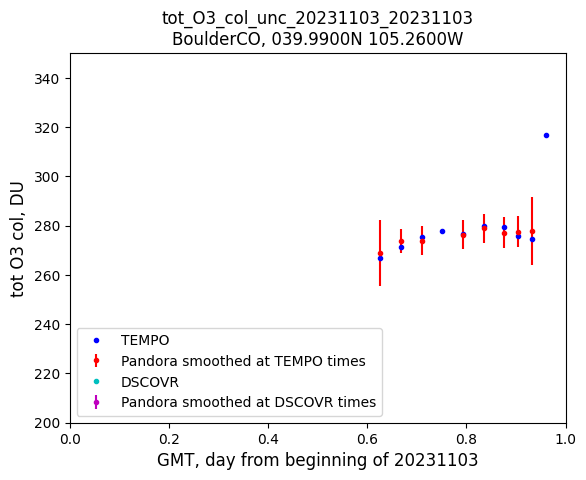

In [ ]:
plot_title = out_Q+'_unc_'+datestamp_ini+'_'+datestamp_fin+'\n'+POI_name
img_name = out_Q+'_unc_'+'_'+datestamp_ini+'_'+datestamp_fin+'_'+POI_name+'.jpg'

fig = plt.figure()

plt.errorbar(time_series_TEMPO[:, 0], time_series_TEMPO[:, 1],\
yerr=None, label = "TEMPO", c = 'b', ls = '', marker = ".")

plt.errorbar(timeseries_Pandora_TEMPO[:, 0],\
             timeseries_Pandora_TEMPO[:, 1],\
             yerr=timeseries_Pandora_TEMPO[:, 2],\
             label = "Pandora smoothed at TEMPO times",\
             c = 'r', ls = '', marker = ".")

plt.errorbar(time_series_DSCOVR[:, 0], time_series_DSCOVR[:, 1],\
yerr=None, label = "DSCOVR", c = 'c', ls = '', marker = ".")

plt.errorbar(timeseries_Pandora_DSCOVR[:, 0],\
             timeseries_Pandora_DSCOVR[:, 1],\
             yerr=timeseries_Pandora_DSCOVR[:, 2],\
             label = "Pandora smoothed at DSCOVR times",\
             c = 'm', ls = '', marker = ".")

# Set the range of x-axis
l_lim = int(min(time_series_TEMPO[:, 0]))
u_lim = int(max(time_series_TEMPO[:, 0])) + 1
plt.xlim(l_lim, u_lim)

# Set the range of y-axis
l_lim = 200
u_lim = 350
plt.ylim(l_lim, u_lim)

# some research is required to set the vertical range
plt.xlabel(r'GMT, day from beginning of '+datestamp_ini, fontsize=12)
plt.ylabel(out_Q_unit.replace('_',' '), fontsize=12)

#plt.legend(loc='lower left')
#plt.legend(loc='upper left')
plt.legend(loc='lower left')

plt.title(plot_title+str(', %08.4fN %08.4fW' %(POI[0], -POI[1])))
plt.savefig(img_name, format='jpg', dpi=300)
